# Perturbation Consistency Analysis

This notebook analyzes the consistency of LLM grading under surface-level code perturbations.

**Analyses:**
1. **Exact Score Agreement Rate** - Grouped bar chart showing % of identical scores
2. **Mean Absolute Difference** - Histograms of (perturbed - original) scores
3. **Quadratically Weighted Cohen's κ** - Self-consistency measure (heatmap)
4. **Scatter Plot** - Original vs Perturbed scores across categories


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import cohen_kappa_score
import warnings
import os
warnings.filterwarnings('ignore')

# Set style for publication-quality figures
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 150

# Create output directory
os.makedirs('results/analysis/batch1', exist_ok=True)
print("Setup complete ✓")


/Users/maohuijun/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Setup complete ✓


In [2]:
# Load perturbation test results
df = pd.read_csv('results/analysis/perturbation_test_results.csv')
print(f"Loaded {len(df)} perturbation test results")
print(f"\nColumns: {list(df.columns)}")

# Configuration
CATEGORIES = ['input', 'logic', 'syntax', 'print']
CATEGORY_LABELS = {
    'input': 'Input Handling',
    'logic': 'Conditional Logic',
    'syntax': 'Syntax Errors',
    'print': 'Print Statements'
}

# Colors
SINGLE_LLM_COLOR = '#3B82F6'  # Blue
MULTI_LLM_COLOR = '#14B8A6'   # Teal

print("\nData preview:")
df.head()


Loaded 100 perturbation test results

Columns: ['student_id', 'code', 'perturbed_code', 'changes_made', 'original_initial_input', 'original_initial_logic', 'original_initial_syntax', 'original_initial_print', 'original_final_input', 'original_final_logic', 'original_final_syntax', 'original_final_print', 'perturbed_initial_input', 'perturbed_initial_logic', 'perturbed_initial_syntax', 'perturbed_initial_print', 'perturbed_final_input', 'perturbed_final_logic', 'perturbed_final_syntax', 'perturbed_final_print']

Data preview:


,student_id,code,perturbed_code,changes_made,original_initial_input,original_initial_logic,original_initial_syntax,original_initial_print,original_final_input,original_final_logic,original_final_syntax,original_final_print,perturbed_initial_input,perturbed_initial_logic,perturbed_initial_syntax,perturbed_initial_print,perturbed_final_input,perturbed_final_logic,perturbed_final_syntax,perturbed_final_print
0,FWMhWHBo9mQCw4fYPeA8GfJPQXO2,def main():\n # TODO write your solution he...,def main():\n # Prompt user for their heigh...,Renamed variable 'height' to 'user_height_mete...,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0
1,3Q7yfPTmBwY24XotEUDSQbDPhcn2,HEIGHT_MINIMUM = 1.6\nHEIGHT_MAXIMUM = 1.9\n\n...,# Minimum and maximum allowed astronaut height...,Renamed HEIGHT_MINIMUM to ASTRONAUT_HEIGHT_MIN...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,euiprXnBDsModVmfCfYnPsm9fBu1,"def main():\n your_height = float(input(""En...",def main():\n # Prompt the user to enter th...,Renamed variable 'your_height' to 'candidate_h...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,OIwVtuci3aRUB44HqGUEt23KrYp2,def main():\n # ask user to enter height in...,def main():\n # Prompt the user to input th...,Renamed variable 'user_height' to 'height_in_m...,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0
4,2wLrL7ik4RP0mJ356HyYn9Ahnpz1,def main():\n # TODO write your solution he...,def main_function():\n # Entry point for th...,Renamed the function 'main' to 'main_function'...,2,2,0,2,2,2,0,2,2,2,0,2,2,2,0,2


## 1. Exact Score Agreement Rate

Percentage of submissions where original and perturbed scores are identical.


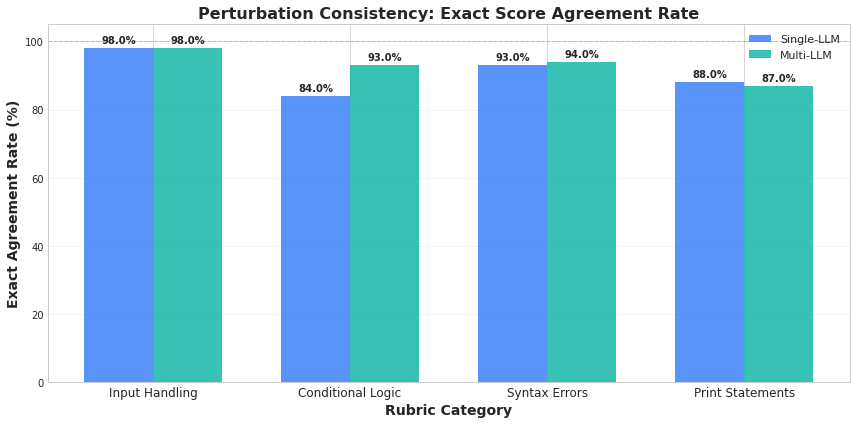


EXACT SCORE AGREEMENT SUMMARY
Input Handling (Single-LLM): 98.0% (100 samples)
Input Handling (Multi-LLM): 98.0% (100 samples)
Conditional Logic (Single-LLM): 84.0% (100 samples)
Conditional Logic (Multi-LLM): 93.0% (100 samples)
Syntax Errors (Single-LLM): 93.0% (100 samples)
Syntax Errors (Multi-LLM): 94.0% (100 samples)
Print Statements (Single-LLM): 88.0% (100 samples)
Print Statements (Multi-LLM): 87.0% (100 samples)

Overall Single-LLM: 90.8%
Overall Multi-LLM: 93.0%


In [3]:
def calculate_agreement_rates(df):
    """Calculate exact agreement rates for each category and grader type."""
    results = {'category': [], 'grader_type': [], 'agreement_rate': [], 'n_valid': []}
    
    for cat in CATEGORIES:
        # Single-LLM (initial)
        orig_col = f'original_initial_{cat}'
        pert_col = f'perturbed_initial_{cat}'
        mask = df[orig_col].notna() & df[pert_col].notna()
        if mask.sum() > 0:
            agreement = (df.loc[mask, orig_col] == df.loc[mask, pert_col]).mean() * 100
            results['category'].append(cat)
            results['grader_type'].append('Single-LLM')
            results['agreement_rate'].append(agreement)
            results['n_valid'].append(mask.sum())
        
        # Multi-LLM (final)
        orig_col = f'original_final_{cat}'
        pert_col = f'perturbed_final_{cat}'
        mask = df[orig_col].notna() & df[pert_col].notna()
        if mask.sum() > 0:
            agreement = (df.loc[mask, orig_col] == df.loc[mask, pert_col]).mean() * 100
            results['category'].append(cat)
            results['grader_type'].append('Multi-LLM')
            results['agreement_rate'].append(agreement)
            results['n_valid'].append(mask.sum())
    
    return pd.DataFrame(results)

# Calculate agreement rates
agreement_df = calculate_agreement_rates(df)

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(CATEGORIES))
width = 0.35

single_rates = agreement_df[agreement_df['grader_type'] == 'Single-LLM']['agreement_rate'].values
multi_rates = agreement_df[agreement_df['grader_type'] == 'Multi-LLM']['agreement_rate'].values

bars1 = ax.bar(x - width/2, single_rates, width, label='Single-LLM', color=SINGLE_LLM_COLOR, alpha=0.85)
bars2 = ax.bar(x + width/2, multi_rates, width, label='Multi-LLM', color=MULTI_LLM_COLOR, alpha=0.85)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Rubric Category', fontsize=14, fontweight='bold')
ax.set_ylabel('Exact Agreement Rate (%)', fontsize=14, fontweight='bold')
ax.set_title('Perturbation Consistency: Exact Score Agreement Rate', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([CATEGORY_LABELS[c] for c in CATEGORIES], fontsize=12)
ax.set_ylim(0, 105)
ax.legend(loc='upper right', fontsize=11)
ax.axhline(y=100, color='#10B981', linestyle='--', alpha=0.5, linewidth=1)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('results/analysis/batch1/perturbation_agreement_rate.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print("\n" + "="*60)
print("EXACT SCORE AGREEMENT SUMMARY")
print("="*60)
for _, row in agreement_df.iterrows():
    print(f"{CATEGORY_LABELS[row['category']]} ({row['grader_type']}): {row['agreement_rate']:.1f}% ({int(row['n_valid'])} samples)")

# Overall averages
single_avg = agreement_df[agreement_df['grader_type'] == 'Single-LLM']['agreement_rate'].mean()
multi_avg = agreement_df[agreement_df['grader_type'] == 'Multi-LLM']['agreement_rate'].mean()
print(f"\nOverall Single-LLM: {single_avg:.1f}%")
print(f"Overall Multi-LLM: {multi_avg:.1f}%")


## 2. Mean Absolute Difference


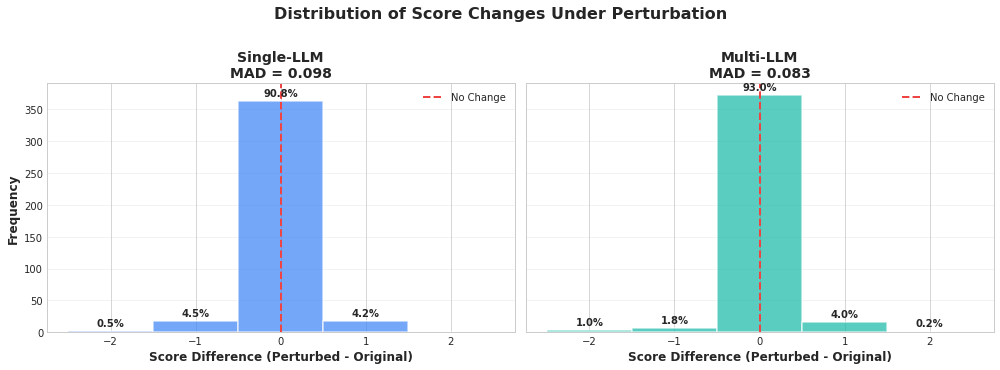


SCORE DIFFERENCE SUMMARY

Single-LLM:
  Mean Absolute Difference (MAD): 0.098
  Mean Difference: -0.013
  Std Difference: 0.328
  % No Change: 90.8%

Multi-LLM:
  Mean Absolute Difference (MAD): 0.083
  Mean Difference: 0.007
  Std Difference: 0.328
  % No Change: 93.0%


In [4]:
def calculate_score_differences(df):
    """Calculate (perturbed - original) differences for all categories."""
    single_diffs = []
    multi_diffs = []
    
    for cat in CATEGORIES:
        # Single-LLM
        orig_col = f'original_initial_{cat}'
        pert_col = f'perturbed_initial_{cat}'
        mask = df[orig_col].notna() & df[pert_col].notna()
        if mask.sum() > 0:
            diffs = df.loc[mask, pert_col] - df.loc[mask, orig_col]
            single_diffs.extend(diffs.tolist())
        
        # Multi-LLM
        orig_col = f'original_final_{cat}'
        pert_col = f'perturbed_final_{cat}'
        mask = df[orig_col].notna() & df[pert_col].notna()
        if mask.sum() > 0:
            diffs = df.loc[mask, pert_col] - df.loc[mask, orig_col]
            multi_diffs.extend(diffs.tolist())
    
    return single_diffs, multi_diffs

# Calculate differences
single_diffs, multi_diffs = calculate_score_differences(df)

# Create side-by-side histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Single-LLM histogram
ax1 = axes[0]
bins = np.arange(-2.5, 3, 1)
ax1.hist(single_diffs, bins=bins, color=SINGLE_LLM_COLOR, alpha=0.7, edgecolor='white', linewidth=1.5)
ax1.axvline(x=0, color='#EF4444', linestyle='--', linewidth=2, label='No Change')
ax1.set_xlabel('Score Difference (Perturbed - Original)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax1.set_title(f'Single-LLM\nMAD = {np.mean(np.abs(single_diffs)):.3f}', fontsize=14, fontweight='bold')
ax1.set_xticks([-2, -1, 0, 1, 2])
ax1.legend(loc='upper right')
ax1.grid(axis='y', alpha=0.3)

# Add percentage labels
total = len(single_diffs)
for i in range(-2, 3):
    count = single_diffs.count(i)
    if count > 0:
        ax1.annotate(f'{count/total*100:.1f}%', xy=(i, count), 
                    xytext=(0, 5), textcoords='offset points',
                    ha='center', fontsize=10, fontweight='bold')

# Multi-LLM histogram
ax2 = axes[1]
ax2.hist(multi_diffs, bins=bins, color=MULTI_LLM_COLOR, alpha=0.7, edgecolor='white', linewidth=1.5)
ax2.axvline(x=0, color='#EF4444', linestyle='--', linewidth=2, label='No Change')
ax2.set_xlabel('Score Difference (Perturbed - Original)', fontsize=12, fontweight='bold')
ax2.set_title(f'Multi-LLM\nMAD = {np.mean(np.abs(multi_diffs)):.3f}', fontsize=14, fontweight='bold')
ax2.set_xticks([-2, -1, 0, 1, 2])
ax2.legend(loc='upper right')
ax2.grid(axis='y', alpha=0.3)

# Add percentage labels
total = len(multi_diffs)
for i in range(-2, 3):
    count = multi_diffs.count(i)
    if count > 0:
        ax2.annotate(f'{count/total*100:.1f}%', xy=(i, count), 
                    xytext=(0, 5), textcoords='offset points',
                    ha='center', fontsize=10, fontweight='bold')

fig.suptitle('Distribution of Score Changes Under Perturbation', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('results/analysis/batch1/perturbation_score_differences.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("SCORE DIFFERENCE SUMMARY")
print("="*60)
print(f"\nSingle-LLM:")
print(f"  Mean Absolute Difference (MAD): {np.mean(np.abs(single_diffs)):.3f}")
print(f"  Mean Difference: {np.mean(single_diffs):.3f}")
print(f"  Std Difference: {np.std(single_diffs):.3f}")
print(f"  % No Change: {single_diffs.count(0)/len(single_diffs)*100:.1f}%")

print(f"\nMulti-LLM:")
print(f"  Mean Absolute Difference (MAD): {np.mean(np.abs(multi_diffs)):.3f}")
print(f"  Mean Difference: {np.mean(multi_diffs):.3f}")
print(f"  Std Difference: {np.std(multi_diffs):.3f}")
print(f"  % No Change: {multi_diffs.count(0)/len(multi_diffs)*100:.1f}%")


## 3. Self-Consistency Kappa


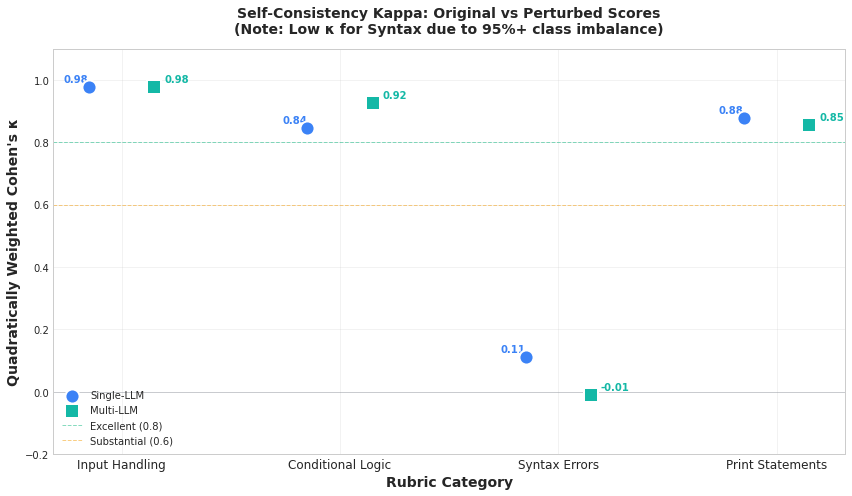


SELF-CONSISTENCY KAPPA SUMMARY

Note: κ can be low despite high agreement when class imbalance is severe
      (e.g., syntax errors where 90%+ are score 0)


Single-LLM:
  Input Handling: κ=0.977, Agreement=98.0%, Class Imbalance=85.0%
  Conditional Logic: κ=0.844, Agreement=84.0%, Class Imbalance=46.0%
  Syntax Errors: κ=0.112, Agreement=93.0%, Class Imbalance=95.5%
  Print Statements: κ=0.878, Agreement=88.0%, Class Imbalance=46.5%

Multi-LLM:
  Input Handling: κ=0.977, Agreement=98.0%, Class Imbalance=87.0%
  Conditional Logic: κ=0.924, Agreement=93.0%, Class Imbalance=55.0%
  Syntax Errors: κ=-0.011, Agreement=94.0%, Class Imbalance=97.0%
  Print Statements: κ=0.854, Agreement=87.0%, Class Imbalance=47.5%

Overall Single-LLM κ: 0.703
Overall Multi-LLM κ: 0.686


In [9]:
def calculate_self_consistency_kappa(df):
    """
    Calculate quadratically weighted Cohen's kappa treating 
    original vs perturbed as two annotators.
    
    Note: Kappa can be low even with high agreement when class imbalance is severe
    (e.g., syntax errors where 90%+ are score 0).
    """
    results = {'category': [], 'grader_type': [], 'kappa': [], 'agreement': [], 'class_imbalance': []}
    
    for cat in CATEGORIES:
        for grader_type, prefix in [('Single-LLM', 'initial'), ('Multi-LLM', 'final')]:
            orig_col = f'original_{prefix}_{cat}'
            pert_col = f'perturbed_{prefix}_{cat}'
            mask = df[orig_col].notna() & df[pert_col].notna()
            
            if mask.sum() > 1:
                orig = df.loc[mask, orig_col].astype(int)
                pert = df.loc[mask, pert_col].astype(int)
                
                # Calculate agreement
                agreement = (orig == pert).mean() * 100
                
                # Calculate class imbalance (% of mode class)
                all_values = pd.concat([orig, pert])
                imbalance = all_values.value_counts().iloc[0] / len(all_values) * 100
                
                # Calculate kappa
                try:
                    kappa = cohen_kappa_score(orig, pert, weights='quadratic', labels=[0, 1, 2])
                except:
                    kappa = np.nan
                
                results['category'].append(cat)
                results['grader_type'].append(grader_type)
                results['kappa'].append(kappa)
                results['agreement'].append(agreement)
                results['class_imbalance'].append(imbalance)
    
    return pd.DataFrame(results)

# Calculate kappa values
kappa_df = calculate_self_consistency_kappa(df)

# Create DOT PLOT instead of heatmap
fig, ax = plt.subplots(figsize=(12, 7))

x_positions = np.arange(len(CATEGORIES))
offset = 0.15

# Single-LLM - Circle
single_kappas = kappa_df[kappa_df['grader_type'] == 'Single-LLM']['kappa'].values
ax.scatter(x_positions - offset, single_kappas, 
           marker='o', s=200, color=SINGLE_LLM_COLOR, edgecolor='white', linewidth=2,
           label='Single-LLM', zorder=5)

# Multi-LLM - Square
multi_kappas = kappa_df[kappa_df['grader_type'] == 'Multi-LLM']['kappa'].values
ax.scatter(x_positions + offset, multi_kappas, 
           marker='s', s=200, color=MULTI_LLM_COLOR, edgecolor='white', linewidth=2,
           label='Multi-LLM', zorder=5)

# Add value labels
for i, (sk, mk) in enumerate(zip(single_kappas, multi_kappas)):
    ax.annotate(f'{sk:.2f}', (i - offset, sk), textcoords='offset points',
               xytext=(-25, 5), fontsize=10, fontweight='bold', color=SINGLE_LLM_COLOR)
    ax.annotate(f'{mk:.2f}', (i + offset, mk), textcoords='offset points',
               xytext=(10, 5), fontsize=10, fontweight='bold', color=MULTI_LLM_COLOR)

# Reference lines
ax.axhline(y=0.8, color='#10B981', linestyle='--', alpha=0.5, linewidth=1, label='Excellent (0.8)')
ax.axhline(y=0.6, color='#F59E0B', linestyle='--', alpha=0.5, linewidth=1, label='Substantial (0.6)')
ax.axhline(y=0, color='#6B7280', linestyle='-', alpha=0.3, linewidth=1)

ax.set_xlabel('Rubric Category', fontsize=14, fontweight='bold')
ax.set_ylabel("Quadratically Weighted Cohen's κ", fontsize=14, fontweight='bold')
ax.set_title("Self-Consistency Kappa: Original vs Perturbed Scores\n(Note: Low κ for Syntax due to 95%+ class imbalance)", 
            fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x_positions)
ax.set_xticklabels([CATEGORY_LABELS[c] for c in CATEGORIES], fontsize=12)
ax.set_ylim(-0.2, 1.1)
ax.legend(loc='lower left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/analysis/batch1/perturbation_self_consistency_kappa.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed summary
print("\n" + "="*70)
print("SELF-CONSISTENCY KAPPA SUMMARY")
print("="*70)
print("\nNote: κ can be low despite high agreement when class imbalance is severe")
print("      (e.g., syntax errors where 90%+ are score 0)\n")

for grader in ['Single-LLM', 'Multi-LLM']:
    print(f"\n{grader}:")
    subset = kappa_df[kappa_df['grader_type'] == grader]
    for _, row in subset.iterrows():
        print(f"  {CATEGORY_LABELS[row['category']]}: κ={row['kappa']:.3f}, "
              f"Agreement={row['agreement']:.1f}%, Class Imbalance={row['class_imbalance']:.1f}%")

print(f"\nOverall Single-LLM κ: {single_kappas.mean():.3f}")
print(f"Overall Multi-LLM κ: {multi_kappas.mean():.3f}")


## 4. Scatter Plot: Original vs Perturbed Scores


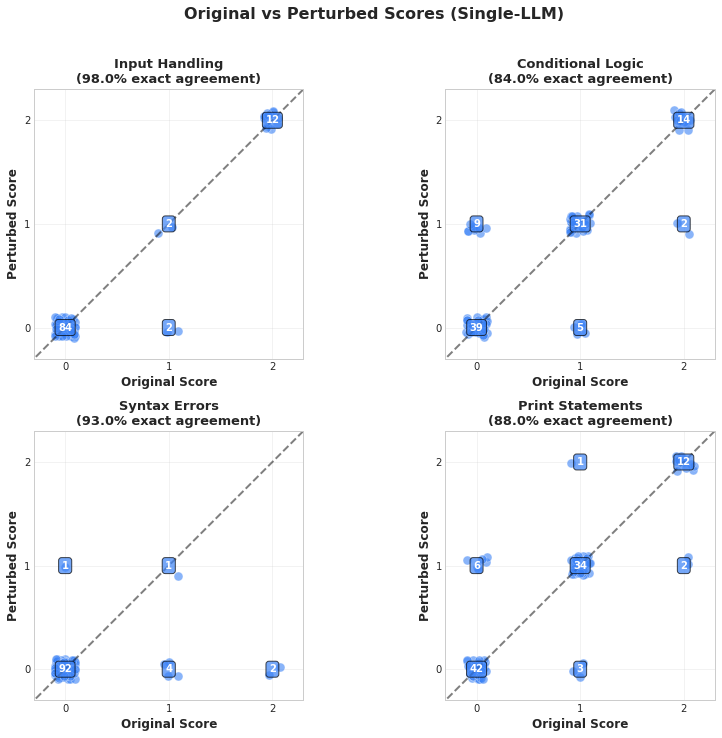

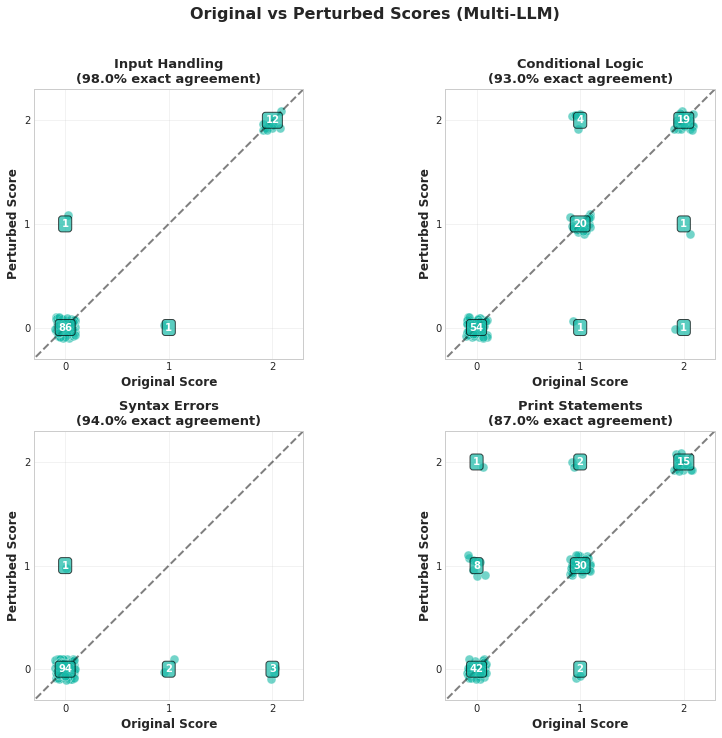

In [6]:
def create_scatter_plots(df, grader_type='initial', color='#3B82F6', title_suffix='Single-LLM'):
    """
    Create scatter plot with original (x) vs perturbed (y) scores.
    One dot per submission, across all 4 categories in a 2x2 grid.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for idx, cat in enumerate(CATEGORIES):
        ax = axes[idx]
        
        orig_col = f'original_{grader_type}_{cat}'
        pert_col = f'perturbed_{grader_type}_{cat}'
        
        # Get valid data
        mask = df[orig_col].notna() & df[pert_col].notna()
        x = df.loc[mask, orig_col]
        y = df.loc[mask, pert_col]
        
        # Add jitter for better visualization
        jitter = 0.1
        x_jittered = x + np.random.uniform(-jitter, jitter, len(x))
        y_jittered = y + np.random.uniform(-jitter, jitter, len(y))
        
        # Scatter plot
        ax.scatter(x_jittered, y_jittered, alpha=0.6, s=80, color=color, 
                  edgecolor='white', linewidth=0.5)
        
        # Perfect agreement line
        ax.plot([-0.5, 2.5], [-0.5, 2.5], 'k--', alpha=0.5, linewidth=2, label='Perfect Agreement')
        
        # Calculate agreement stats
        agreement = (x == y).mean() * 100
        
        ax.set_xlabel('Original Score', fontsize=12, fontweight='bold')
        ax.set_ylabel('Perturbed Score', fontsize=12, fontweight='bold')
        ax.set_title(f'{CATEGORY_LABELS[cat]}\n({agreement:.1f}% exact agreement)', 
                    fontsize=13, fontweight='bold')
        ax.set_xlim(-0.3, 2.3)
        ax.set_ylim(-0.3, 2.3)
        ax.set_xticks([0, 1, 2])
        ax.set_yticks([0, 1, 2])
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        # Add count annotations in each cell
        for orig in [0, 1, 2]:
            for pert in [0, 1, 2]:
                count = ((x == orig) & (y == pert)).sum()
                if count > 0:
                    ax.annotate(str(count), xy=(orig, pert), ha='center', va='center',
                               fontsize=10, fontweight='bold', color='white',
                               bbox=dict(boxstyle='round', facecolor=color, alpha=0.7))
    
    fig.suptitle(f'Original vs Perturbed Scores ({title_suffix})', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig

# Create scatter plots for Single-LLM
fig_single = create_scatter_plots(df, 'initial', SINGLE_LLM_COLOR, 'Single-LLM')
plt.savefig('results/analysis/batch1/perturbation_scatter_single_llm.png', dpi=300, bbox_inches='tight')
plt.show()

# Create scatter plots for Multi-LLM
fig_multi = create_scatter_plots(df, 'final', MULTI_LLM_COLOR, 'Multi-LLM')
plt.savefig('results/analysis/batch1/perturbation_scatter_multi_llm.png', dpi=300, bbox_inches='tight')
plt.show()


## Summary


In [ ]:
# This cell should be run AFTER cell 14 (extract inconsistent cases)
# Moving summary to the end


PERTURBATION CONSISTENCY ANALYSIS - FINAL SUMMARY

Total Submissions Analyzed: 100
Categories: input, logic, syntax, print

----------------------------------------------------------------------
1. EXACT AGREEMENT RATE
----------------------------------------------------------------------
   Single-LLM: 90.8%
   Multi-LLM:  93.0%

----------------------------------------------------------------------
2. MEAN ABSOLUTE DIFFERENCE (MAD)
----------------------------------------------------------------------
   Single-LLM: 0.098
   Multi-LLM:  0.083

----------------------------------------------------------------------
3. SELF-CONSISTENCY KAPPA (Average)
----------------------------------------------------------------------
   Single-LLM: 0.703
   Multi-LLM:  0.686

FILES SAVED:
  - results/analysis/batch1/perturbation_agreement_rate.png
  - results/analysis/batch1/perturbation_score_differences.png
  - results/analysis/batch1/perturbation_self_consistency_kappa.png
  - results/analysis/ba

## 5. Extract Inconsistent Cases

Save codes that failed perturbation consistency to separate files (8 files: 4 categories × 2 LLM types)


In [10]:
def extract_inconsistent_cases(df, output_dir='results/analysis/batch1/inconsistent_cases'):
    """
    Extract codes where original and perturbed scores differ.
    Save to 8 separate files (4 categories × 2 LLM types).
    """
    os.makedirs(output_dir, exist_ok=True)
    
    summary = []
    
    for cat in CATEGORIES:
        for grader_type, prefix in [('single_llm', 'initial'), ('multi_llm', 'final')]:
            orig_col = f'original_{prefix}_{cat}'
            pert_col = f'perturbed_{prefix}_{cat}'
            
            # Find inconsistent cases
            mask = (df[orig_col].notna() & df[pert_col].notna() & 
                    (df[orig_col] != df[pert_col]))
            
            inconsistent_df = df.loc[mask, [
                'student_id', 'code', 'perturbed_code', 'changes_made',
                orig_col, pert_col
            ]].copy()
            
            # Add score change column
            inconsistent_df['score_change'] = inconsistent_df[pert_col] - inconsistent_df[orig_col]
            
            # Rename columns for clarity
            inconsistent_df = inconsistent_df.rename(columns={
                orig_col: 'original_score',
                pert_col: 'perturbed_score'
            })
            
            # Save to file
            filename = f'{grader_type}_{cat}_inconsistent.csv'
            filepath = os.path.join(output_dir, filename)
            inconsistent_df.to_csv(filepath, index=False)
            
            summary.append({
                'category': cat,
                'grader_type': grader_type.replace('_', '-').upper(),
                'num_inconsistent': len(inconsistent_df),
                'filename': filename
            })
            
            print(f"Saved {len(inconsistent_df)} inconsistent cases to {filename}")
    
    return pd.DataFrame(summary)

# Extract and save inconsistent cases
print("="*70)
print("EXTRACTING INCONSISTENT CASES")
print("="*70)
print()

inconsistent_summary = extract_inconsistent_cases(df)

print("\n" + "="*70)
print("SUMMARY OF INCONSISTENT CASES")
print("="*70)
print(inconsistent_summary.to_string(index=False))

# Also create a combined view showing what changed
print("\n" + "="*70)
print("BREAKDOWN OF SCORE CHANGES")
print("="*70)

for cat in CATEGORIES:
    for grader_type, prefix in [('Single-LLM', 'initial'), ('Multi-LLM', 'final')]:
        orig_col = f'original_{prefix}_{cat}'
        pert_col = f'perturbed_{prefix}_{cat}'
        
        mask = (df[orig_col].notna() & df[pert_col].notna() & 
                (df[orig_col] != df[pert_col]))
        
        if mask.sum() > 0:
            changes = df.loc[mask, pert_col] - df.loc[mask, orig_col]
            stricter = (changes > 0).sum()  # Perturbed got higher (worse) score
            lenient = (changes < 0).sum()   # Perturbed got lower (better) score
            
            print(f"\n{CATEGORY_LABELS[cat]} ({grader_type}): {mask.sum()} inconsistent")
            print(f"  → More strict on perturbed: {stricter}")
            print(f"  → More lenient on perturbed: {lenient}")


EXTRACTING INCONSISTENT CASES

Saved 2 inconsistent cases to single_llm_input_inconsistent.csv
Saved 2 inconsistent cases to multi_llm_input_inconsistent.csv
Saved 16 inconsistent cases to single_llm_logic_inconsistent.csv
Saved 7 inconsistent cases to multi_llm_logic_inconsistent.csv
Saved 7 inconsistent cases to single_llm_syntax_inconsistent.csv
Saved 6 inconsistent cases to multi_llm_syntax_inconsistent.csv
Saved 12 inconsistent cases to single_llm_print_inconsistent.csv
Saved 13 inconsistent cases to multi_llm_print_inconsistent.csv

SUMMARY OF INCONSISTENT CASES
category grader_type  num_inconsistent                           filename
   input  SINGLE-LLM                 2  single_llm_input_inconsistent.csv
   input   MULTI-LLM                 2   multi_llm_input_inconsistent.csv
   logic  SINGLE-LLM                16  single_llm_logic_inconsistent.csv
   logic   MULTI-LLM                 7   multi_llm_logic_inconsistent.csv
  syntax  SINGLE-LLM                 7 single_llm_synta

print("="*70)
print("PERTURBATION CONSISTENCY ANALYSIS - FINAL SUMMARY")
print("="*70)

print(f"\nTotal Submissions Analyzed: {len(df)}")
print(f"Categories: {', '.join(CATEGORIES)}")

print("\n" + "-"*70)
print("1. EXACT AGREEMENT RATE")
print("-"*70)
single_agreement = agreement_df[agreement_df['grader_type'] == 'Single-LLM']['agreement_rate'].mean()
multi_agreement = agreement_df[agreement_df['grader_type'] == 'Multi-LLM']['agreement_rate'].mean()
print(f"   Single-LLM: {single_agreement:.1f}%")
print(f"   Multi-LLM:  {multi_agreement:.1f}%")

print("\n" + "-"*70)
print("2. MEAN ABSOLUTE DIFFERENCE (MAD)")
print("-"*70)
print(f"   Single-LLM: {np.mean(np.abs(single_diffs)):.3f}")
print(f"   Multi-LLM:  {np.mean(np.abs(multi_diffs)):.3f}")

print("\n" + "-"*70)
print("3. SELF-CONSISTENCY KAPPA (Average)")
print("-"*70)
single_kappa_avg = kappa_df[kappa_df['grader_type'] == 'Single-LLM']['kappa'].mean()
multi_kappa_avg = kappa_df[kappa_df['grader_type'] == 'Multi-LLM']['kappa'].mean()
print(f"   Single-LLM: {single_kappa_avg:.3f}")
print(f"   Multi-LLM:  {multi_kappa_avg:.3f}")

print("\n" + "-"*70)
print("4. INCONSISTENT CASES EXTRACTED")
print("-"*70)
total_single = inconsistent_summary[inconsistent_summary['grader_type'] == 'SINGLE-LLM']['num_inconsistent'].sum()
total_multi = inconsistent_summary[inconsistent_summary['grader_type'] == 'MULTI-LLM']['num_inconsistent'].sum()
print(f"   Single-LLM: {total_single} inconsistent cases (across all categories)")
print(f"   Multi-LLM:  {total_multi} inconsistent cases (across all categories)")

print("\n" + "="*70)
print("FILES SAVED:")
print("="*70)
print("  Plots:")
print("    - results/analysis/batch1/perturbation_agreement_rate.png")
print("    - results/analysis/batch1/perturbation_score_differences.png")
print("    - results/analysis/batch1/perturbation_self_consistency_kappa.png")
print("    - results/analysis/batch1/perturbation_scatter_single_llm.png")
print("    - results/analysis/batch1/perturbation_scatter_multi_llm.png")
print("  Inconsistent Cases (8 files):")
print("    - results/analysis/batch1/inconsistent_cases/single_llm_*.csv")
print("    - results/analysis/batch1/inconsistent_cases/multi_llm_*.csv")

# Conclusion
print("\n" + "="*70)
print("CONCLUSION")
print("="*70)
if multi_agreement > single_agreement:
    print(f"✓ Multi-LLM shows HIGHER consistency ({multi_agreement:.1f}% vs {single_agreement:.1f}%)")
elif single_agreement > multi_agreement:
    print(f"✗ Single-LLM shows HIGHER consistency ({single_agreement:.1f}% vs {multi_agreement:.1f}%)")
else:
    print(f"= Both systems show EQUAL consistency ({single_agreement:.1f}%)")
